In [2]:
save_dats_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/paper1/dats/'

In [4]:
from glob import glob
import pandas as pd
import fastwer
import numpy as np
import matplotlib.pyplot as plt
import re

import Levenshtein
import fastwer

from sys import path
path.append('../../')

# debug
from importlib import reload
import utils
reload(utils)

from utils import split_function_with_delimiters_with_checks as spc
from utils import get_fill_in_types, align_texts_fast, fix_ocr

search_doc = r"\\(?:[^a-zA-Z]|[a-zA-Z]+[*=']?)" # search for commands in the document itself

# have some weird marks that don't show up in our text
marks = {'citations':'↫','refs':'↷','inlines':'↭'}

In [5]:
# make reverse marks
marks_rev = {}
for k,v in marks.items():
    marks_rev[v] = k
marks_rev

{'↫': 'citations', '↷': 'refs', '↭': 'inlines'}

## Batch inference byt5 -- only words, arXiv dataset

In [6]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/latex/'

ender = '_small_words' # 100k for training, 5k val

In [7]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words = d.copy()
    else: # others
        df_byt5_words = pd.concat([df_byt5_words,d],ignore_index=True)

In [8]:
df_byt5_words.head()

,aligned sentences source,aligned sentences target,sentences source,sentences target,aligned sentences source types,aligned sentences target types,sentences source types,sentences target types,words source aligned,words target aligned,input_text,target_text,predicted_text
0,Thev suegested that optical {lis [rom the neu...,They suggested that optical flux from the neu...,Thev suegested that optical {lis [rom the neu...,They suggested that optical flux from the neu...,WWWW WWWWWWWWW WWWW WWWWWWW WWWW WWWW WWW WWW...,WWWW WWWWWWWWW WWWW WWWWWWW WWWW WWWW WWW WWW...,WWWW WWWWWWWWW WWWW WWWWWWW WWWW WWWW WWW WWW...,WWWW WWWWWWWWW WWWW WWWWWWW WWWW WWWW WWW WWW...,Thev suegested that optical {lis [rom the neu...,They suggested that optical flux from the neu...,Thev suegested that optical {lis [rom the neu...,They suggested that optical flux from the neu...,They suggested that optical flux from the neu...
1,dust. temperatures of 35. 40. 45 and SOWKK are...,"dust@ temperatures of 35, 40, 45 and @@@K@ are...",dust. temperatures of 35. 40. 45 and SOWKK are...,"dust temperatures of 35, 40, 45 and K are abou...",WWWWW WWWWWWWWWWWW WW WWW WWW WW WWW WWWWW WWW...,WWWW@ WWWWWWWWWWWW WW WWW WWW WW WWW @@@W@ WWW...,WWWWW WWWWWWWWWWWW WW WWW WWW WW WWW WWWWW WWW...,WWWW WWWWWWWWWWWW WW WWW WWW WW WWW W WWW WWWW...,dust. temperatures of 35. 40. 45 and KK are ab...,"dust@ temperatures of 35, 40, 45 and K@ are ab...",dust. temperatures of 35. 40. 45 and KK are ab...,"dust temperatures of 35, 40, 45 and K are abou...","dust temperatures of 35, 40, 45 and K are abou..."
2,| comparison between the two panels demonstra...,A comparison between the two panels demonstra...,| comparison between the two panels demonstra...,A comparison between the two panels demonstra...,W WWWWWWWWWW WWWWWWW WWW WWW WWWWWW WWWWWWWWW...,W WWWWWWWWWW WWWWWWW WWW WWW WWWWWW WWWWWWWWW...,W WWWWWWWWWW WWWWWWW WWW WWW WWWWWW WWWWWWWWW...,W WWWWWWWWWW WWWWWWW WWW WWW WWWWWW WWWWWWWWW...,| comparison between the two panels demonstra...,A comparison between the two panels demonstra...,| comparison between the two panels demonstra...,A comparison between the two panels demonstra...,A comparison between the two panels demonstra...
3,Then. equation ^^^^^^^^^^^(7)^) aud equation ...,"Then, equation \ref{con_ang}) ) and equation ...",Then. equation (7)) aud equation (3)) can be ...,"Then, equation \ref{con_ang}) ) and equation ...",WWWWW WWWWWWWW ^^^^^^^^^^^WWW^W WWW WWWWWWWW ...,WWWWW WWWWWWWW RRRRRRRRRRRRRW W WWW WWWWWWWW ...,WWWWW WWWWWWWW WWWW WWW WWWWWWWW WWWW WWW WW ...,WWWWW WWWWWWWW RRRRRRRRRRRRRW W WWW WWWWWWWW ...,Then. equation )@) aud equation )@) can be so...,"Then, equation ) ) and equation ) ) can be so...",Then. equation )) aud equation )) can be solv...,"Then, equation ) ) and equation ) ) can be so...","Then, equation ) ) and equation ) ) can be so..."
4,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,WW WWWW WWWWWWWWW W WWWWWW WWWWW WW WWWWWWWW ...,WW WWWW WWWWWWWWW W WWWWWW WWWWW WW WWWWWWWW ...,WW WWWW WWWWWWWWW W WWWWWW WWWWW WW WWWWWWWW ...,WW WWWW WWWWWWWWW W WWWWWW WWWWW WW WWWWWWWW ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...


In [13]:
def calc_cer_wer(df_byt5_words, input_text_col = 'input_text', 
                target_text_col='target_text', predicted_text_col='predicted_text'):
    # input_text = OCR source in
    # target_text = ground truth 
    # predicted_text = predicted OCR text
    cer_before = []; cer_after = []
    wer_before = []; wer_after = []
    for i in range(len(df_byt5_words)):
        d = df_byt5_words.iloc[i]
        # before
        if not pd.isnull(d[input_text_col]) and not pd.isnull(d[target_text_col]) and not pd.isnull(d[predicted_text_col]):
            # also, for ints/floats that got read in
            input_text = str(d[input_text_col])
            target_text = str(d[target_text_col])
            predicted_text = str(d[predicted_text_col])
            cbefore = fastwer.score_sent(input_text,
                                         target_text,
                                         char_level=True)
            wbefore = fastwer.score_sent(input_text,
                                         target_text,
                                         char_level=False)
            # after
            cafter = fastwer.score_sent(predicted_text,
                                         target_text,
                                         char_level=True)
            wafter = fastwer.score_sent(predicted_text,
                                         target_text,
                                         char_level=False)
        else:
            cbefore = np.nan
            wbefore = np.nan
            cafter = np.nan
            wafter = np.nan

        cer_before.append(cbefore)
        wer_before.append(wbefore)
        cer_after.append(cafter)
        wer_after.append(wafter)

    df_byt5_words['CER Before'] = cer_before
    df_byt5_words['WER Before'] = wer_before
    df_byt5_words['CER After'] = cer_after
    df_byt5_words['WER After'] = wer_after
    return df_byt5_words

In [10]:
#df_byt5_words = calc_cer_wer(df_byt5_words.copy())

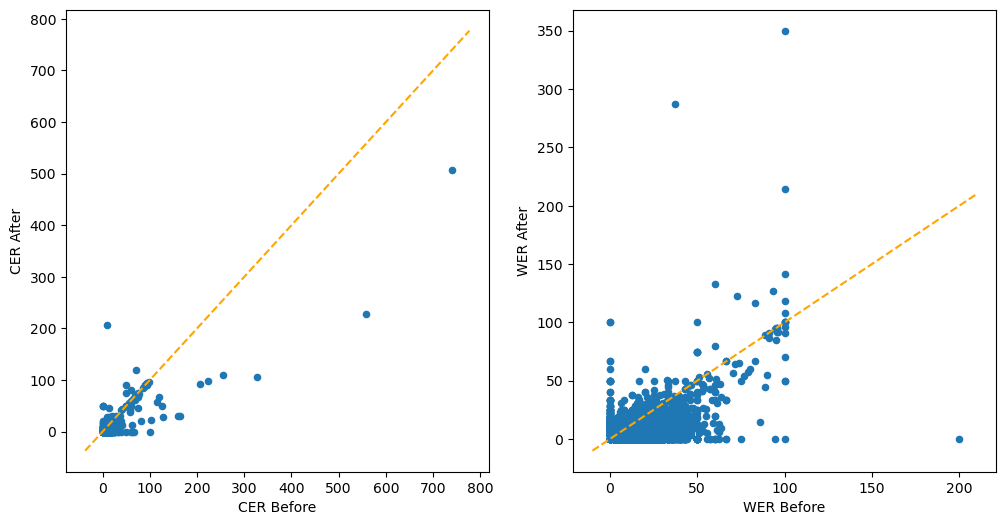

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df_byt5_words.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

df_byt5_words.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [14]:
def get_iqr(df_byt5_words,col):
    colvalue = df_byt5_words[col]
    colvalue = colvalue[~np.isnan(colvalue)]
    Q3 = np.quantile(colvalue, 0.75)
    Q1 = np.quantile(colvalue, 0.25)
    IQR = Q3 - Q1
    return IQR

In [15]:
def get_iqr_by_value(colvalue):
    Q3 = np.quantile(colvalue, 0.75)
    Q1 = np.quantile(colvalue, 0.25)
    IQR = Q3 - Q1
    return IQR

In [16]:
def get_stats(df_byt5_words,col, round_val = 2, print_nans=False):
    colvalue = df_byt5_words[col]
    colvalue = colvalue[~np.isnan(colvalue)]
    # how many nan's
    if print_nans: print('# NaNs =', len(df_byt5_words[col])-len(colvalue))
    med = colvalue.median()
    mea = colvalue.mean()
    std = colvalue.std()
    iqr = get_iqr_by_value(colvalue)
    return round(mea,round_val), round(med,round_val), round(std,round_val), round(iqr,round_val)

In [17]:
def get_improvement_stats(df_byt5_words,col_before, col_after, round_val = 2):
    colvalueb = df_byt5_words[col_before]
    colvalueb = colvalueb[~np.isnan(colvalueb)]
    colvaluea = df_byt5_words[col_after]
    colvaluea = colvaluea[~np.isnan(colvaluea)]
    mask = colvalueb != 0
    colvalue = 100*(1-colvaluea[mask]/colvalueb[mask])
    med = colvalue.median()
    mea = colvalue.mean()
    std = colvalue.std()
    iqr = get_iqr_by_value(colvalue)
    return round(mea,round_val), round(med,round_val), round(std,round_val), round(iqr,round_val)    

In [18]:
# x = 9.6
# format(x, '.2f')

In [19]:
def save_dat(fname,data,formatting = None, round_val = 2):
    if formatting == ',':
        all_arts = "{:,}".format(successful_align_pages)
    elif formatting == 'zfill':
        all_arts = data
        if 'NaN' not in str(all_arts):
            all_arts = format(all_arts,'.'+str(round_val)+'f')
    else:
        all_arts = data
    with open(fname, 'w') as f:
        print(all_arts, file=f,end='')

In [20]:
def get_print_stats(df_byt5_words, before='Before', after = 'After'):
    print('--------- Before -------------')
    mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words,'CER '+before, print_nans=True)
    print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
    mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words,'WER '+before)
    print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
    print('')
    print('--------- After -------------')
    mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words,'CER '+after)
    print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
    mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words,'WER '+after)
    print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
    print('')
    # improvement
    #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
    mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words,'CER '+before, 'CER '+after)
    print('------------ Improvement ----------------')
    print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
    mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words,'WER '+before, 'WER '+after)
    print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)
    # numbers of better and worse
    # CER after should be < CER before if the model is corrected
    mask = df_byt5_words['CER '+before] < df_byt5_words['CER ' + after] # CER should go down after correction -- cer before correction < cer after is wrong -- how many wrong?
    print('CER : How many better =', len(df_byt5_words[~mask]), ', how many worse (or same) =', len(df_byt5_words[mask]), 
          ', % better =', round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2))
    cerImp = round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2)
    mask = df_byt5_words['WER '+before] < df_byt5_words['WER ' + after]
    print('WER : How many better =', len(df_byt5_words[~mask]), ', how many worse (or same) =', len(df_byt5_words[mask]), 
         ', % better =', round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2))
    werImp = round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2)
    
    return mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp

In [19]:
# print('')
# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
#      mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
#      mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_full_fix, before=before, after = after)

In [20]:
# before = 'Before'; after = 'After'

# print('--------- Before -------------')
# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words,'CER Before', print_nans=True)
# print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
# mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words,'WER Before')
# print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
# print('')
# print('--------- After -------------')
# mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words,'CER After')
# print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
# mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words,'WER After')
# print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
# print('')
# # improvement
# #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
# mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words,'CER Before', 'CER After')
# print('------------ Improvement ----------------')
# print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
# mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words,'WER Before', 'WER After')
# print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)
# # # numbers of better and worse
# # mask = test_data['CER '+before] < test_data['CER ' + after] # CER should go down after correction -- cer before correction < cer after is wrong -- how many wrong?
# # print('CER : How many better =', len(df_byt5_words[~mask]), ', how many worse (or same) =', len(df_byt5_words[mask]), 
# #       ', % better =', round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2))
# # cerImp = round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2)
# # mask = test_data['WER '+before] < test_data['WER ' + after]
# # print('WER : How many better =', len(df_byt5_words[~mask]), ', how many worse (or same) =', len(df_byt5_words[mask]), 
# #      ', % better =', round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2))
# # werImp = round(len(df_byt5_words[~mask])/len(df_byt5_words)*100,2)
# # # save all of these

mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words, before='Before', after = 'After')

--------- Before -------------
# NaNs = 35
CER : mean = 5.5 , std = 17.46 , median = 3.01 , iqr = 5.22
WER : mean = 15.34 , std = 14.53 , median = 13.04 , iqr = 17.46

--------- After -------------
CER : mean = 2.37 , std = 11.29 , median = 0.35 , iqr = 1.77
WER : mean = 6.46 , std = 13.44 , median = 2.13 , iqr = 8.82

------------ Improvement ----------------
CER : mean =  67.35 , std = 60.25 , median = 83.33 , iqr = 50.0
WER : mean =  60.18 , std = 59.94 , median = 80.0 , iqr = 50.0
CER : How many better = 4650 , how many worse (or same) = 350 , % better = 93.0
WER : How many better = 4519 , how many worse (or same) = 481 , % better = 90.38


~~Also try with combining the full dataset:~~ this actually kills the kernel!

In [21]:
# before_all = ''; after_all = ''
# input_text_col = 'input_text'
# target_text_col='target_text'
# predicted_text_col='predicted_text'

# predicted_text_all = ''
# target_text_all = ''
# input_text_all = ''

# for i in range(len(df_byt5_words)):
#     d = df_byt5_words.iloc[i]
#     # before
#     if not pd.isnull(d[input_text_col]) and not pd.isnull(d[target_text_col]) and not pd.isnull(d[predicted_text_col]):
#         # also, for ints/floats that got read in
#         input_text = str(d[input_text_col])
#         target_text = str(d[target_text_col])
#         predicted_text = str(d[predicted_text_col])
        
#         predicted_text_all += predicted_text
#         target_text_all += target_text
#         input_text_all += input_text
        
# print('done')

# cbefore = fastwer.score_sent(input_text_all,
#                              target_text_all,
#                              char_level=True)
# wbefore = fastwer.score_sent(input_text_all,
#                              target_text_all,
#                              char_level=False)
# # after
# cafter = fastwer.score_sent(predicted_text_all,
#                              target_text_all,
#                              char_level=True)
# wafter = fastwer.score_sent(predicted_text_all,
#                              target_text_all,
#                              char_level=False)

# print(len(predicted_text_all), len(target_text_all), len(input_text_all))
# print(cbefore, wbefore)
# print(cafter,wafter)

In [22]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w,cerImp,werImp]
names_start = 'byt5_onlyWords_small'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp','cerImp','werImp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d,formatting='zfill')

## Byt5, Historical, Only Words

In [23]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/historical/'
ender = '_small_words' # 100k for training, 5k val (in the arxiv data)

In [24]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_h = d.copy()
    else: # others
        df_byt5_words_h = pd.concat([df_byt5_words_h,d],ignore_index=True)

In [25]:
df_byt5_words_h.head()

,input_text_unclean,target_text_unclean,filename,page,sent num,type,input_text,target_text,predicted_text
0,"In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he...",1905ApJ____22____1R,0,3,plain,"In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he..."
1,*Both the nebula and the comet are seen on a n...,"""Both the nebula and the comet are seen on a n...",1907ApJ____25__218B,9,0,plain,*Both the nebula and the comet are seen on a n...,"""Both the nebula and the comet are seen on a n...",Both the nebula and the comet are seen on a n...
2,"A plate can be exposed night after night, if d...","A plate can be exposed night after night, if d...",1910ApJ____32___26R,6,11,plain,"A plate can be exposed night after night, if d...","A plate can be exposed night after night, if d...","A plate can be exposed night after night, if d..."
3,"ture only, we must assume that, as we ascend t...","ture only, we must assume that, as we ascend t...",1913ApJ____38__407M,86,0,plain,"ture only, we must assume that, as we ascend t...","ture only, we must assume that, as we ascend t...","ture only, we must assume that, as we ascend t..."
4,"An image of it was pro-jected upon the plate, ...","An image of it was projected upon the plate, g...",1916ApJ____44___65W,4,3,plain,"An image of it was pro-jected upon the plate, ...","An image of it was projected upon the plate, g...","An image of it was pro-jected upon the plate, ..."


In [26]:
df_byt5_words_h = calc_cer_wer(df_byt5_words_h.copy())

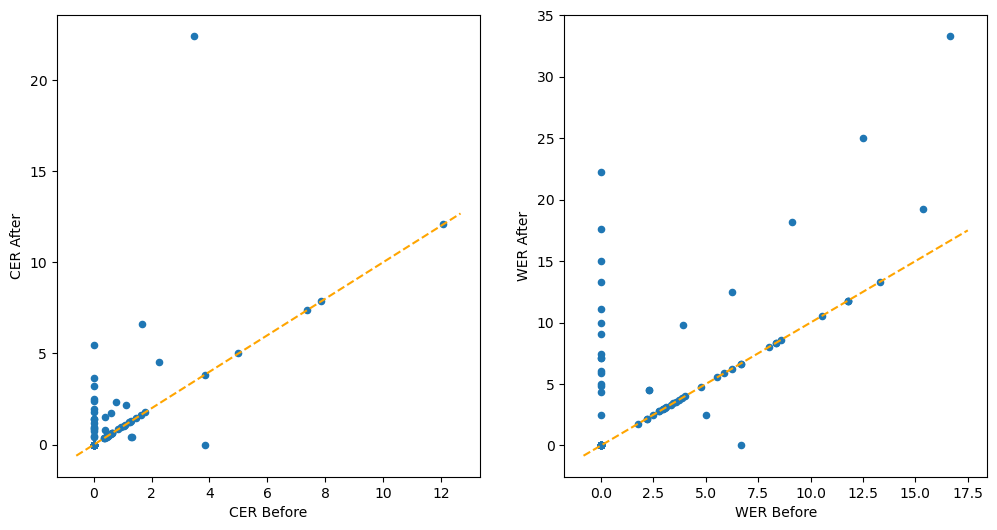

In [27]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df_byt5_words_h.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

df_byt5_words_h.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [28]:
# print('--------- Before -------------')
# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words_h,'CER Before', print_nans=True)
# print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
# mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words_h,'WER Before')
# print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
# print('')
# print('--------- After -------------')
# mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words_h,'CER After')
# print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
# mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words_h,'WER After')
# print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
# print('')
# # improvement
# #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
# mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words_h,'CER Before', 'CER After')
# print('------------ Improvement ----------------')
# print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
# mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words_h,'WER Before', 'WER After')
# print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)

# # save all of these
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_h, before='Before', after = 'After')

--------- Before -------------
# NaNs = 0
CER : mean = 0.68 , std = 1.71 , median = 0.0 , iqr = 0.59
WER : mean = 2.37 , std = 3.9 , median = 0.0 , iqr = 3.48

--------- After -------------
CER : mean = 1.19 , std = 2.79 , median = 0.37 , iqr = 1.18
WER : mean = 4.21 , std = 6.1 , median = 2.17 , iqr = 6.35

------------ Improvement ----------------
CER : mean =  -39.43 , std = 117.01 , median = 0.0 , iqr = 0.0
WER : mean =  -15.24 , std = 46.39 , median = 0.0 , iqr = 0.0
CER : How many better = 84 , how many worse (or same) = 24 , % better = 77.78
WER : How many better = 84 , how many worse (or same) = 24 , % better = 77.78


So, just with words, doesn't really fix anything, which is interesting.

## byt5, full, arxiv

In [29]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/latex_full/'

ender = '_full_large' # 100k for training, 5k val

In [30]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_full = d.copy()
    else: # others
        df_byt5_words_full = pd.concat([df_byt5_words_full,d],ignore_index=True)

In [31]:
df_byt5_words_full.head()

,aligned sentences source,aligned sentences target,input_text,target_text,aligned sentences source types,aligned sentences target types,sentences source types,sentences target types,predicted_text
0,A histogram of the ^^^^^^^Va^^^ /slope for dw...,A histogram of the $_{\rm max}$ /slope for dw...,A histogram of the Va /slope for dwarf irregu...,A histogram of the $_{\rm max}$ /slope for dw...,W WWWWWWWWW WW WWW ^^^^^^^II^^^ WWWWWW WWW WW...,W WWWWWWWWW WW WWW IIIIIIIIIIII WWWWWW WWW WW...,W WWWWWWWWW WW WWW II WWWWWW WWW WWWWW WWWWWW...,W WWWWWWWWW WW WWW IIIIIIIIIIII WWWWWW WWW WW...,A histogram of the $V_{\rm d}$ /slope for dwa...
1,We conclude that there does not appear to he ...,We conclude that there does not appear to be ...,We conclude that there does not appear to he ...,We conclude that there does not appear to be ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,We conclude that there does not appear to be ...
2,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,The central mass is surrounded by a quasi-sta...
3,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,This means that the BAT is well suited for fi...
4,In general. it is well established that the m...,"In general, it is well established that the m...",In general. it is well established that the m...,"In general, it is well established that the m...",WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,"In general, it is well established that the m..."


In [32]:
df_byt5_words_full = calc_cer_wer(df_byt5_words_full.copy())

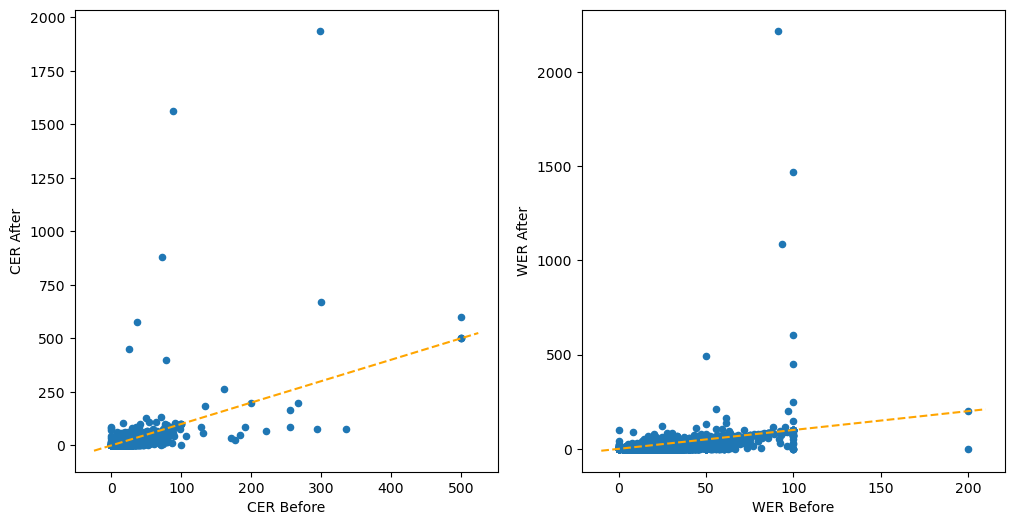

In [33]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df_byt5_words_full.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

df_byt5_words_full.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [34]:
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_full, before='Before', after = 'After')

--------- Before -------------
# NaNs = 114
CER : mean = 12.53 , std = 18.58 , median = 8.11 , iqr = 14.79
WER : mean = 19.81 , std = 15.67 , median = 17.65 , iqr = 19.08

--------- After -------------
CER : mean = 7.18 , std = 32.54 , median = 1.49 , iqr = 8.6
WER : mean = 8.92 , std = 33.06 , median = 3.85 , iqr = 11.11

------------ Improvement ----------------
CER : mean =  58.49 , std = 81.33 , median = 72.73 , iqr = 60.0
WER : mean =  60.77 , std = 57.17 , median = 71.43 , iqr = 60.0
CER : How many better = 9433 , how many worse (or same) = 567 , % better = 94.33
WER : How many better = 9614 , how many worse (or same) = 386 , % better = 96.14


In [35]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w, cerImp, werImp]
names_start = 'byt5_full_large'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp', 'cerImp', 'werImp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d,formatting='zfill')

## byt5, full, with fixes

In [36]:
marks

{'citations': '↫', 'refs': '↷', 'inlines': '↭'}

In [37]:
# check that special marks aren't in the words just yet
for i in range(len(df_byt5_words_full)):
    d = df_byt5_words_full.iloc[i]
    for m in marks.values():
        #if m in d['input_text'] or m in d['target_text']:
        if m in str(d['target_text']):
            import sys; sys.exit()

In [38]:
df_byt5_words_full_fix = fix_ocr(df_byt5_words_full.copy(),marks=marks)

no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!


How many NaN's?

In [39]:
len(df_byt5_words_full_fix.loc[pd.isnull(df_byt5_words_full_fix['CER Fix'])])

198

In [40]:
df_byt5_words_full_fix.head()

,aligned sentences source,aligned sentences target,input_text,target_text,aligned sentences source types,aligned sentences target types,sentences source types,sentences target types,predicted_text,CER Before,...,WER Orig,CER Corrected,WER Corrected,CER Fix Corrected,WER Fix Corrected,CER Fix,WER Fix,target_text_fixed,predicted_text_fixed,masked entries
0,A histogram of the ^^^^^^^Va^^^ /slope for dw...,A histogram of the $_{\rm max}$ /slope for dw...,A histogram of the Va /slope for dwarf irregu...,A histogram of the $_{\rm max}$ /slope for dw...,W WWWWWWWWW WW WWW ^^^^^^^II^^^ WWWWWW WWW WW...,W WWWWWWWWW WW WWW IIIIIIIIIIII WWWWWW WWW WW...,W WWWWWWWWW WW WWW II WWWWWW WWW WWWWW WWWWWW...,W WWWWWWWWW WW WWW IIIIIIIIIIII WWWWWW WWW WW...,A histogram of the $V_{\rm d}$ /slope for dwa...,18.5393,...,25.0000,7.8652,9.3750,0.0000,0.0000,8.9172,22.5806,A histogram of the ↭ /slope for dwarf irregul...,A histogram of the ↭ /slope for dwarf irregul...,True
1,We conclude that there does not appear to he ...,We conclude that there does not appear to be ...,We conclude that there does not appear to he ...,We conclude that there does not appear to be ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,We conclude that there does not appear to be ...,4.5802,...,16.0000,0.0000,0.0000,0.0000,0.0000,4.5802,16.0000,We conclude that there does not appear to be ...,We conclude that there does not appear to be ...,True
2,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,The central mass is surrounded by a quasi-sta...,5.0000,...,7.6923,0.0000,0.0000,0.0000,0.0000,5.0000,7.6923,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,True
3,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,This means that the BAT is well suited for fi...,4.3478,...,6.8966,0.0000,0.0000,0.0000,0.0000,4.3478,6.8966,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,True
4,In general. it is well established that the m...,"In general, it is well established that the m...",In general. it is well established that the m...,"In general, it is well established that the m...",WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,"In general, it is well established that the m...",4.8346,...,15.0000,0.7634,1.6667,0.7732,1.6949,3.6082,13.5593,"In general, it is well established that the m...","In general, it is well established that the m...",True


In [41]:
# df_byt5_words_full_fix = calc_cer_wer(df_byt5_words_full_fix.copy(), 
#                                       target_text_col='target_text_fixed', 
#                                      predicted_text_col = 'predicted_text_fixed')
# already calc'd in the fixing!

In [42]:
#df_byt5_words_full_fix.columns

In [43]:
#df_byt5_words_full_fix.plot(x='CER After', y = 'CER Fix Corrected') # why are these the same????

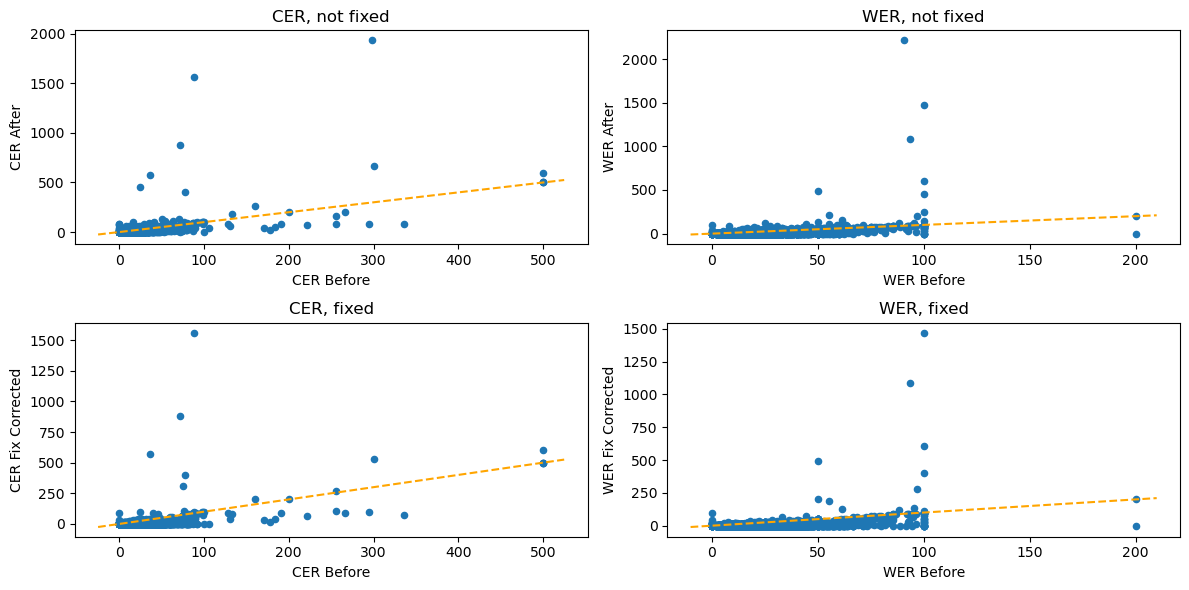

In [44]:
fig, ax = plt.subplots(2,2,figsize=(12,6))
ax = ax.flatten()
df_byt5_words_full_fix.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[0].set_title('CER, not fixed')

df_byt5_words_full_fix.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[1].set_title('WER, not fixed')

# fixed
iplot = 2
df_byt5_words_full_fix.plot(x = 'CER Before', y = 'CER Fix Corrected', kind='scatter',ax=ax[iplot])
xlim = ax[iplot].get_xlim()
ylim = ax[iplot].get_ylim()
ax[iplot].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[iplot].set_title('CER, fixed')

iplot = 3
df_byt5_words_full_fix.plot(x = 'WER Before', y = 'WER Fix Corrected', kind='scatter',ax=ax[iplot])
xlim = ax[iplot].get_xlim()
ylim = ax[iplot].get_ylim()
ax[iplot].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[iplot].set_title('WER, fixed')

fig.tight_layout()

plt.show()

In [45]:
before = 'Before'
after = 'Fix Corrected'

# print('--------- Before -------------')
# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words_full_fix,'CER '+before, print_nans=True)
# print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
# mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words_full_fix,'WER '+before)
# print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
# print('')
# print('--------- After -------------')
# mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words_full_fix,'CER '+after)
# print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
# mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words_full_fix,'WER '+after)
# print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
# print('')
# # improvement
# #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
# mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words_full_fix,'CER '+before, 'CER '+after)
# print('------------ Improvement ----------------')
# print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
# mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words_full_fix,'WER '+before, 'WER '+after)
# print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)
# print('')
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_full_fix, before=before, after = after)

--------- Before -------------
# NaNs = 114
CER : mean = 12.53 , std = 18.58 , median = 8.11 , iqr = 14.79
WER : mean = 19.81 , std = 15.67 , median = 17.65 , iqr = 19.08

--------- After -------------
CER : mean = 2.47 , std = 24.07 , median = 0.0 , iqr = 1.4
WER : mean = 3.84 , std = 22.37 , median = 0.0 , iqr = 4.35

------------ Improvement ----------------
CER : mean =  85.51 , std = 44.09 , median = 100.0 , iqr = nan
WER : mean =  84.44 , std = 35.38 , median = 100.0 , iqr = nan
CER : How many better = 9822 , how many worse (or same) = 178 , % better = 98.22
WER : How many better = 9924 , how many worse (or same) = 76 , % better = 99.24


In [46]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w,cerImp, werImp]
names_start = 'byt5_full_large_fix'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp', 'cerImp', 'werImp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d,formatting='zfill')

## byt5, full, classification

In [47]:
def make_classification_metrics(dfout_err_h, target_text_col='target_text_fixed',
                               predicted_text_col='predicted_text_fixed',
                               marks = marks_rev):
    
    classification_metrics = {'citations':{'FP':0, 'FN':0, 'TP':0, 'total true':0}, 
                              'inlines':{'FP':0, 'FN':0, 'TP':0, 'total true':0},
                              'refs':{'FP':0, 'FN':0, 'TP':0, 'total true':0}}


    for i in range(len(dfout_err_h)):
        d = dfout_err_h.iloc[i]
        # align predicted and target
        page_text_gt = str(d[target_text_col])
        page_text_ocr = str(d[predicted_text_col])
        eops = Levenshtein.editops(page_text_ocr, page_text_gt)
        ocr_text_aligned, pdf_text_aligned = align_texts_fast(page_text_ocr, 
                                                              page_text_gt, 
                                                              eops)
        # loop
        for p,o in zip(pdf_text_aligned,ocr_text_aligned):
            if p in list(marks.keys()): # special mark
                if p == o: # got it!
                    classification_metrics[marks[p]]['total true'] += 1
                    classification_metrics[marks[p]]['TP'] += 1
                elif (p != o) and (o in list(marks.keys())): # not right mark, but in marks
                    classification_metrics[marks[p]]['total true'] += 1
                    classification_metrics[marks[o]]['FP'] += 1
                else: # p is a mark, but missed it in ocr
                    classification_metrics[marks[p]]['total true'] += 1
                    classification_metrics[marks[p]]['FN'] += 1
            elif o in list(marks.keys()): # have ocr instead!
                classification_metrics[marks[o]]['FP'] += 1
    return classification_metrics

def prec_rec_f1(classification_metrics):
    for t,v in classification_metrics.items():
        if v['total true'] > 0: # have it
            print(t)
            print(v)
            #Precision = TruePositives / (TruePositives + FalsePositives)
            if v['TP'] + v["FP"] > 0:
                prec = v['TP']/(v['TP'] + v["FP"])
            else:
                prec = 0
            #Recall = TruePositives / (TruePositives + FalseNegatives)
            if v['TP']+v['FN'] > 0:
                rec = v['TP']/(v['TP']+v['FN'])
            else:
                rec = 0

            # F-Measure = (2 * Precision * Recall) / (Precision + Recall)
            if prec+rec > 0:
                f1 = (2*prec*rec)/(prec+rec)
            else:
                f1 = 0

            print('prec =', prec, ', rec =', rec, ', f1 = ', f1)
            print('')
            classification_metrics[t]['Prec'] = prec
            classification_metrics[t]['Rec'] = rec
            classification_metrics[t]['F1'] = f1
    return classification_metrics

In [48]:
#df_byt5_words_full_fix.head()

In [49]:
classification_metrics_latex = make_classification_metrics(df_byt5_words_full_fix)

In [50]:
print('-------- LaTeX ---------')
classification_metrics_latex = prec_rec_f1(classification_metrics_latex.copy())

-------- LaTeX ---------
citations
{'FP': 62, 'FN': 77, 'TP': 1504, 'total true': 1594}
prec = 0.9604086845466155 , rec = 0.9512966476913346 , f1 =  0.9558309501112171

inlines
{'FP': 539, 'FN': 769, 'TP': 6404, 'total true': 7181}
prec = 0.9223678525133228 , rec = 0.8927924160044611 , f1 =  0.9073391895721168

refs
{'FP': 102, 'FN': 82, 'TP': 968, 'total true': 1053}
prec = 0.9046728971962616 , rec = 0.9219047619047619 , f1 =  0.9132075471698115



In [51]:
classification_metrics_latex

{'citations': {'FP': 62,
  'FN': 77,
  'TP': 1504,
  'total true': 1594,
  'Prec': 0.9604086845466155,
  'Rec': 0.9512966476913346,
  'F1': 0.9558309501112171},
 'inlines': {'FP': 539,
  'FN': 769,
  'TP': 6404,
  'total true': 7181,
  'Prec': 0.9223678525133228,
  'Rec': 0.8927924160044611,
  'F1': 0.9073391895721168},
 'refs': {'FP': 102,
  'FN': 82,
  'TP': 968,
  'total true': 1053,
  'Prec': 0.9046728971962616,
  'Rec': 0.9219047619047619,
  'F1': 0.9132075471698115}}

In [52]:
for k,v in classification_metrics_latex.items():
    fdat = save_dats_dir + 'arxiv_' + k
    p = round(v['Prec']*100,2)
    r = round(v['Rec']*100,2)
    f1 = round(v['F1']*100,2)
    tot = int(v['total true'])
    for m,n in zip([p,r,f1],['prec','rec','f1']):
        save_dat(fdat + '_' + n + '.dat',m,formatting='zfill')
        
    save_dat(fdat + '_' + 'total' + '.dat',tot,formatting='zfill',round_val=0)
    
        # with open(fdat + '_' + n + '.dat','w') as f:
        #     print(m,file=f)

## byt5, NOT fixed historical

In [53]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/historical_full/'

ender = '_full_large' # 500k for training, 10k val (in the arxiv data)

In [54]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_h_full = d.copy()
    else: # others
        df_byt5_words_h_full = pd.concat([df_byt5_words_h_full,d],ignore_index=True)

In [55]:
df_byt5_words_h_full.head()

,input_text,target_text,filename,page,sent num,type,predicted_text,predicted_text_histOnlyModel
0,As a matter of fact Rowland's tables contain n...,As a matter of fact Rowland's tables contain n...,1895ApJ_____2___74H,0,3,plain,As a matter of fact Rowland's tables contain n...,As a matter of fact Rowland's tables contain n...
1,With respect to the application of the apparat...,With respect to the application of the apparat...,1896ApJ_____3__259P,7,1,plain,With respect to the application of the apparat...,Ith respect to the application of the apparatu...
2,"by practical -observa-tion, certain ideas of h...","by practical observation, certain ideas of his...",1900ApJ____11__325K,0,2,plain,"by practical observation, certain ideas of his...","The practical -observation, certain ideas of h..."
3,"In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he...",1905ApJ____22____1R,0,3,plain,"In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he..."
4,This plate is simply to show the extent and ge...,This plate is simply to show the extent and ge...,1907ApJ____25__218B,4,10,plain,This plate is simply to show the extent and ge...,This plate is simply to show the extent and ge...


In [56]:
df_byt5_words_h_full = calc_cer_wer(df_byt5_words_h_full.copy(), 
                                      target_text_col='target_text', 
                                     predicted_text_col = 'predicted_text')

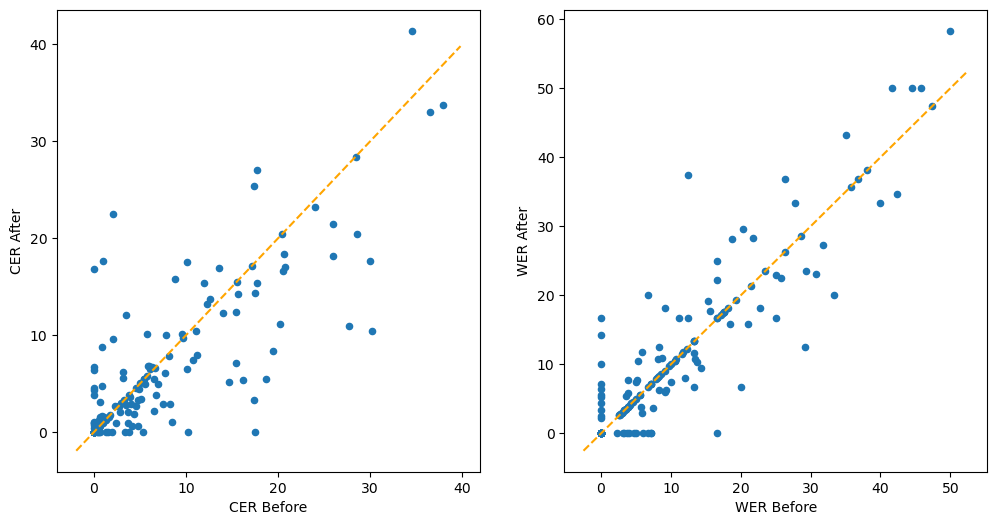

In [57]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df_byt5_words_h_full.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

df_byt5_words_h_full.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [58]:
before='Before'; after = 'After'
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_h_full, before=before, after = after)

--------- Before -------------
# NaNs = 0
CER : mean = 5.53 , std = 8.19 , median = 1.32 , iqr = 7.35
WER : mean = 8.98 , std = 11.35 , median = 4.65 , iqr = 13.33

--------- After -------------
CER : mean = 5.01 , std = 7.42 , median = 1.42 , iqr = 6.71
WER : mean = 9.22 , std = 11.89 , median = 4.77 , iqr = 13.33

------------ Improvement ----------------
CER : mean =  -23.8 , std = 204.98 , median = 0.0 , iqr = 41.03
WER : mean =  3.21 , std = 48.34 , median = 0.0 , iqr = 18.18
CER : How many better = 159 , how many worse (or same) = 43 , % better = 78.71
WER : How many better = 162 , how many worse (or same) = 40 , % better = 80.2


## Byt5, *YES* fixed, historical

In [59]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/historical_full/'

ender = '_full_large' # 500k for training, 10k val (in the arxiv data)

In [60]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_h_full_fix = d.copy()
    else: # others
        df_byt5_words_h_full_fix = pd.concat([df_byt5_words_h_full_fix,d],ignore_index=True)

In [61]:
df_byt5_words_h_full_fix = calc_cer_wer(df_byt5_words_h_full_fix.copy(), 
                                      target_text_col='target_text', 
                                     predicted_text_col = 'predicted_text')
len(df_byt5_words_h_full_fix)

202

In [62]:
# save number of instances
with open(save_dats_dir + 'n_historical.dat', 'w') as f:
    print(int(len(df_byt5_words_h_full_fix)),file=f)

In [63]:
df_byt5_words_h_full_fix = fix_ocr(df_byt5_words_h_full_fix.copy(), marks=marks)

In [64]:
len(df_byt5_words_h_full_fix)

202

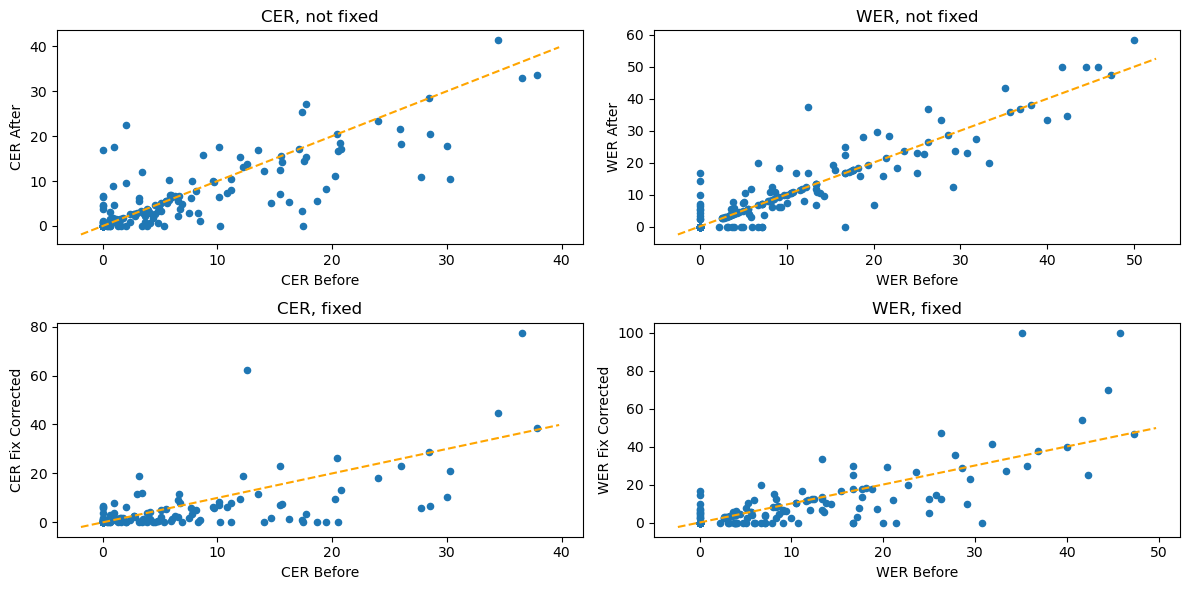

In [65]:
fig, ax = plt.subplots(2,2,figsize=(12,6))
ax = ax.flatten()
df_byt5_words_h_full_fix.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[0].set_title('CER, not fixed')

df_byt5_words_h_full_fix.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[1].set_title('WER, not fixed')

# fixed
iplot = 2
df_byt5_words_h_full_fix.plot(x = 'CER Before', y = 'CER Fix Corrected', kind='scatter',ax=ax[iplot])
xlim = ax[iplot].get_xlim()
ylim = ax[iplot].get_ylim()
ax[iplot].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[iplot].set_title('CER, fixed')

iplot = 3
df_byt5_words_h_full_fix.plot(x = 'WER Before', y = 'WER Fix Corrected', kind='scatter',ax=ax[iplot])
xlim = ax[iplot].get_xlim()
ylim = ax[iplot].get_ylim()
ax[iplot].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')
ax[iplot].set_title('WER, fixed')

# for a in ax:
#     a.set_ylim(-5,100)

fig.tight_layout()

plt.show()

In [66]:
before = 'Before'
after = 'Fix Corrected'

mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_h_full_fix, before=before, after = after)

--------- Before -------------
# NaNs = 0
CER : mean = 5.53 , std = 8.19 , median = 1.32 , iqr = 7.35
WER : mean = 8.98 , std = 11.35 , median = 4.65 , iqr = 13.33

--------- After -------------
CER : mean = 3.94 , std = 9.63 , median = 0.48 , iqr = 3.49
WER : mean = 8.2 , std = 15.06 , median = 2.63 , iqr = 10.53

------------ Improvement ----------------
CER : mean =  7.71 , std = 129.04 , median = 34.32 , iqr = nan
WER : mean =  18.82 , std = 63.61 , median = 4.76 , iqr = nan
CER : How many better = 167 , how many worse (or same) = 35 , % better = 82.67
WER : How many better = 167 , how many worse (or same) = 35 , % better = 82.67


In [67]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w,cerImp,werImp]
names_start = 'byt5_full_large_fix_historical'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp','cerImp', 'werImp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d,formatting='zfill')

In [68]:
# check really big ones
df_byt5_words_h_full_fix.loc[df_byt5_words_h_full_fix['CER Fix Corrected'] > 60]
#df_byt5_words_h_full_fix.loc[df_byt5_words_h_full_fix['CER Fix Corrected'] > df_byt5_words_h_full_fix['CER Before']]

,input_text,target_text,filename,page,sent num,type,predicted_text,predicted_text_histOnlyModel,CER Before,WER Before,...,WER Orig,CER Corrected,WER Corrected,CER Fix Corrected,WER Fix Corrected,CER Fix,WER Fix,target_text_fixed,predicted_text_fixed,masked entries
41,"140 has n = 0.67 and v, = 6.3 X 1014 sec"", but...",140 has $n = 0.67$ and $\nu_c = 6.3 \times 10^...,1964ApJ___140____1G,25,1,plain,140 has $n$ = 0.67 and $v_{\rm r}$ = 6.3 $\tim...,NaN,36.5217,45.8333,...,45.8333,33.0435,50.0000,77.5510,100.0,79.5918,127.2727,"140 has ↭ and ↭, but arises from a volume ↭","140 has ↭ = 0.67 and ↭ = 6.3 ↭ ↭ ↭, but arises...",True
158,"The K magnitude is 6.47, and the near-IR color...","The $K$ magnitude is 6.47, and the near-IR col...",1994ApJ___420__632S,1,30,plain,"The K magnitude is 6.47, and the near-IR color...","The K magnitude is 6.47, and the near-IR color...",12.5749,35.1351,...,35.1351,13.7725,43.2432,62.3853,100.0,61.4679,100.0000,"The ↭ magnitude is 6.47, and the near-IR color...","The K magnitude is 6.47, and the near-IR color...",True


In [69]:
cut = 60
ival = 0
print('input text    :', df_byt5_words_h_full_fix.loc[df_byt5_words_h_full_fix['CER Fix Corrected'] > cut]['input_text'].values[ival])
print('target text   :', df_byt5_words_h_full_fix.loc[df_byt5_words_h_full_fix['CER Fix Corrected'] > cut]['target_text'].values[ival])
print('predicted text:', df_byt5_words_h_full_fix.loc[df_byt5_words_h_full_fix['CER Fix Corrected'] > cut]['predicted_text'].values[ival])
#print('predicted text:', df_byt5_words_h_full_fix.loc[df_byt5_words_h_full_fix['CER Fix Corrected'] > cut]['predicted_text_defaultModel'].values[ival])

input text    : 140 has n = 0.67 and v, = 6.3 X 1014 sec", but arises from a volume V = 4 X 10?
target text   : 140 has $n = 0.67$ and $\nu_c = 6.3 \times 10^{14} \, {\rm sec}^{-1}$, but arises from a volume $V = 4 \times 10^3$
predicted text: 140 has $n$ = 0.67 and $v_{\rm r}$ = 6.3 $\times$ $^{14}$ $^{-1}$, but arises from a volume $V$ = 4 $\times$ $^{-14}$.


In [70]:
classification_metrics_historical = make_classification_metrics(df_byt5_words_h_full_fix, marks=marks_rev)

In [71]:
print('-------- Historical ---------')
classification_metrics_historical = prec_rec_f1(classification_metrics_historical.copy())

-------- Historical ---------
inlines
{'FP': 43, 'FN': 22, 'TP': 114, 'total true': 136}
prec = 0.7261146496815286 , rec = 0.8382352941176471 , f1 =  0.7781569965870307



In [72]:
classification_metrics_historical

{'citations': {'FP': 1, 'FN': 0, 'TP': 0, 'total true': 0},
 'inlines': {'FP': 43,
  'FN': 22,
  'TP': 114,
  'total true': 136,
  'Prec': 0.7261146496815286,
  'Rec': 0.8382352941176471,
  'F1': 0.7781569965870307},
 'refs': {'FP': 4, 'FN': 0, 'TP': 0, 'total true': 0}}

Print out befores/afters if the CER/WER is >0 and unchanged, or has gone down:

In [73]:
for k,v in classification_metrics_historical.items():
    fdat = save_dats_dir + 'historical_class_' + k
    if 'Prec' in v: # if not, then all zeros
        p = round(v['Prec']*100,2)
        r = round(v['Rec']*100,2)
        f1 = round(v['F1']*100,2)
        tot = int(v['total true'])
    else:
        p = 'NaN'; r = 'NaN'; f1 = 'NaN'
        tot = 0
        
    for m,n in zip([p,r,f1],['prec','rec','f1']):
        save_dat(fdat + '_' + n + '.dat',m,formatting='zfill')
        
    save_dat(fdat + '_' + 'total' + '.dat',tot,formatting='zfill',round_val=0)
        
    # save_dat(fdat + '_' + 'total' + '.dat',tot,formatting='zfill',round_val=0)
    # for m,n in zip([p,r,f1,tot],['prec','rec','f1','total']):
    #     with open(fdat + '_' + n + '.dat','w') as f:
    #         if m == 0 and 'tota' not in n:
    #             m = '0.0'
    #         print(m,file=f)

In [74]:
#df_byt5_words_h_full_fix.head()

In [75]:
istart = 0
iend = 3
for i in range(len(df_byt5_words_h_full_fix)):
    d = df_byt5_words_h_full_fix.iloc[i]
    if d['CER Fix Corrected'] >= d['CER Orig'] and d['CER Orig']>0:
        if i > istart and iend < iend:
            print('orig OCR :', d['input_text'])
            print('orig PDF :', d['target_text'])
            print('pred txt :', d['predicted_text'])
            print('')

In [76]:
for i in range(len(df_byt5_words_h_full_fix)):
    d = df_byt5_words_h_full_fix.iloc[i]
    if d['WER Fix Corrected'] >= d['WER Orig'] and d['WER Orig']>0:
        if i > istart and iend < iend:
            print('orig OCR :', d['input_text'])
            print('orig PDF :', d['target_text'])
            print('pred txt :', d['predicted_text'])
            print('')

## byt5, historical, not fixed, just plain byt5-small model (no transfer learning)

In [77]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/historical_full/'

ender = '_full_large' # 500k for training, 10k val (in the arxiv data)

In [78]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_h_full_orig = d.copy()
    else: # others
        df_byt5_words_h_full_orig = pd.concat([df_byt5_words_h_full_orig,d],ignore_index=True)

In [79]:
# df_byt5_words_h_full_orig = calc_cer_wer(df_byt5_words_h_full_orig.copy(), 
#                                       target_text_col='target_text', 
#                                      predicted_text_col = 'predicted_text_histOnlyModel')

In [80]:
# before='Before'
# after = 'After'
# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
#      mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
#      mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_h_full_orig, 
#                                                                                         before=before, after = after)

### With fixing:

In [81]:
# inf_files = glob(output_dir_inf + '*'+ender+'.csv')
# inf_files.sort()
# for i,f in enumerate(inf_files):
#     d = pd.read_csv(f)
#     if i == 0: # first
#         df_byt5_words_h_full_orig_fix = d.copy()
#     else: # others
#         df_byt5_words_h_full_orig_fix = pd.concat([df_byt5_words_h_full_orig_fix,d],ignore_index=True)

In [82]:
# df_byt5_words_h_full_orig_fix = calc_cer_wer(df_byt5_words_h_full_orig_fix.copy(), 
#                                       target_text_col='target_text', 
#                                      predicted_text_col = 'predicted_text_histOnlyModel')

In [83]:
# df_byt5_words_h_full_orig_fix = fix_ocr(df_byt5_words_h_full_orig_fix.copy(), 
#                                         marks=marks, predicted_text_col='predicted_text_histOnlyModel')

In [84]:
# before = 'Before'
# after = 'Fix Corrected'

# mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
#      mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
#      mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp \
#      = get_print_stats(df_byt5_words_h_full_orig_fix, before=before, after = after)

In [85]:
# # save everything
# dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
#         mea_c,mea_w,cerImp,werImp]
# names_start = 'historical_untrained_'
# datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
#             'mean_cer_imp','mean_wer_imp','cerImp', 'werImp']
# for d,n in zip(dats,datnames):
#     save_dat(save_dats_dir+names_start+n+'.dat',d,formatting='zfill',round_val=0)

## byt5, historical data, trained on historical data

In [86]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_h_p = d.copy()
    else: # others
        df_byt5_words_h_p = pd.concat([df_byt5_words_h_p,d],ignore_index=True)

In [87]:
df_byt5_words_h_p.head(n=1)

,input_text,target_text,filename,page,sent num,type,predicted_text,predicted_text_histOnlyModel
0,As a matter of fact Rowland's tables contain n...,As a matter of fact Rowland's tables contain n...,1895ApJ_____2___74H,0,3,plain,As a matter of fact Rowland's tables contain n...,As a matter of fact Rowland's tables contain n...


In [88]:
df_byt5_words_h_p = calc_cer_wer(df_byt5_words_h_p.copy(), 
                                      target_text_col='target_text', 
                                     predicted_text_col = 'predicted_text_histOnlyModel')

In [89]:
df_byt5_words_h_p = fix_ocr(df_byt5_words_h_p.copy(), 
                            marks=marks, predicted_text_col='predicted_text_histOnlyModel')

no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!
no matching $ in OCR corrected fix!


In [90]:
before='Before'
after = 'After'

print(' *************** Not Fixed ******************** ')
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_h_p, 
                                                                                        before=before, after = after)

 *************** Not Fixed ******************** 
--------- Before -------------
# NaNs = 20
CER : mean = 4.68 , std = 7.44 , median = 0.89 , iqr = 5.96
WER : mean = 7.83 , std = 10.63 , median = 3.85 , iqr = 11.43

--------- After -------------
CER : mean = 29.46 , std = 151.51 , median = 3.99 , iqr = 17.86
WER : mean = 31.76 , std = 139.08 , median = 8.05 , iqr = 25.0

------------ Improvement ----------------
CER : mean =  -387.66 , std = 1205.65 , median = 0.0 , iqr = 189.68
WER : mean =  -172.46 , std = 725.94 , median = 0.0 , iqr = 114.28
CER : How many better = 117 , how many worse (or same) = 85 , % better = 57.92
WER : How many better = 123 , how many worse (or same) = 79 , % better = 60.89


In [91]:
#df_byt5_words_h_p.columns

In [92]:
before = 'Before'
after = 'Fix Corrected'

print(' *************** Fixed ******************** ')

mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp \
     = get_print_stats(df_byt5_words_h_p, before=before, after = after)

 *************** Fixed ******************** 
--------- Before -------------
# NaNs = 20
CER : mean = 4.68 , std = 7.44 , median = 0.89 , iqr = 5.96
WER : mean = 7.83 , std = 10.63 , median = 3.85 , iqr = 11.43

--------- After -------------
CER : mean = 30.84 , std = 144.29 , median = 2.41 , iqr = 19.46
WER : mean = 34.59 , std = 145.78 , median = 6.45 , iqr = 25.37

------------ Improvement ----------------
CER : mean =  -443.18 , std = 1216.33 , median = 0.0 , iqr = nan
WER : mean =  -209.74 , std = 790.87 , median = -12.5 , iqr = nan
CER : How many better = 128 , how many worse (or same) = 74 , % better = 63.37
WER : How many better = 122 , how many worse (or same) = 80 , % better = 60.4


In [93]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w,cerImp,werImp]
names_start = 'historical_onlyHist_'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp','cerImp', 'werImp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d,formatting='zfill',round_val=2)

## byt5, historical data, with the yelpfeast model

This is the model from [yelpfeast ocr post correction](https://huggingface.co/yelpfeast/byt5-base-english-ocr-correction).

In [36]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/historical_untrained/'

ender = '_untrained' # untrained

In [37]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_untrained = d.copy()
    else: # others
        df_byt5_words_untrained = pd.concat([df_byt5_words_untrained,d],ignore_index=True)

In [38]:
#d

In [39]:
df_byt5_words_untrained.head(n=2)

,input_text_unclean,target_text_unclean,filename,page,sent num,type,input_text,target_text,predicted_text
0,As a matter of fact Rowland's tables contain n...,As a matter of fact Rowland's tables contain n...,1895ApJ_____2___74H,0,3,plain,As a matter of fact Rowland's tables contain n...,As a matter of fact Rowland's tables contain n...,As a matter of fact Rowland's tables contain n...
1,With respect to the application of the apparat...,With respect to the application of the apparat...,1896ApJ_____3__259P,7,1,plain,With respect to the application of the apparat...,With respect to the application of the apparat...,With respect to the application of the apparat...


In [40]:
#df_byt5_words_untrained['predicted_text_histOnlyModel'].values

In [41]:
df_byt5_words_untrained = calc_cer_wer(df_byt5_words_untrained.copy(), 
                                      target_text_col='target_text', 
                                     predicted_text_col = 'predicted_text')

In [42]:
before='Before'
after = 'After'

print(' *************** Not Fixed ******************** ')
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore, mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore, \
     mea_cafter,med_cafter,std_cafter,iqr_cafter, mea_wafter,med_wafter,std_wafter,iqr_wafter, \
     mea_c,med_c,std_c,iqr_c, mea_w,med_w,std_w,iqr_w, cerImp, werImp = get_print_stats(df_byt5_words_untrained, 
                                                                                        before=before, after = after)

 *************** Not Fixed ******************** 
--------- Before -------------
# NaNs = 0
CER : mean = 0.57 , std = 1.49 , median = 0.0 , iqr = 0.53
WER : mean = 2.18 , std = 4.15 , median = 0.0 , iqr = 3.28

--------- After -------------
CER : mean = 13.39 , std = 23.96 , median = 1.86 , iqr = 7.81
WER : mean = 20.12 , std = 23.65 , median = 10.91 , iqr = 17.28

------------ Improvement ----------------
CER : mean =  -2499.35 , std = 4270.87 , median = -199.99 , iqr = 3137.52
WER : mean =  -499.26 , std = 699.02 , median = -200.0 , iqr = 525.0
CER : How many better = 33 , how many worse (or same) = 169 , % better = 16.34
WER : How many better = 35 , how many worse (or same) = 167 , % better = 17.33
